In [1]:
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import os

# Define label column names
LABEL_COLUMNS = ["Positive_Emotions", "Negative_Emotions", "Self_Esteem", "Meaning_in_Life", "Social_Support"]

# Number of Folds
NUM_FOLDS = 5
fold_files = [f"train_2d_fold{i}.pkl" for i in range(1, NUM_FOLDS + 1)]

# Create directory for saving models
os.makedirs("2Ddata_LSTM", exist_ok=True)

# ===== Step 1: Compute Global Max Sequence Length Across All Folds ===== #
global_max_seq_length = 0

for file_name in fold_files:
    with open(file_name, "rb") as f:
        fold_dict = pickle.load(f)
    max_length = max(len(seq) for seq in fold_dict["data"])
    global_max_seq_length = max(global_max_seq_length, max_length)

print(f"\n✅ Global Max Sequence Length: {global_max_seq_length}")

# ===== Step 2: Standardize Features Using a Single Scaler ===== #
scaler = StandardScaler()

# Fit scaler on the first fold's training data
with open(fold_files[0], "rb") as f:
    first_fold_dict = pickle.load(f)

columns = first_fold_dict["columns"]
label_indices = [columns.index(col) for col in LABEL_COLUMNS]
feature_indices = [i for i in range(len(columns)) if i not in label_indices and columns[i] != "participant_id"]

X_raw_first_fold = [np.array(seq[:, feature_indices], dtype=np.float32) for seq in first_fold_dict["data"]]
X_flattened = np.vstack(X_raw_first_fold)
scaler.fit(X_flattened)

# Save Scaler
with open("2Ddata_LSTM/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ StandardScaler saved!")

# ===== Step 3: Train LSTM Model Across Folds ===== #
cv_results = {"train_loss": [], "val_loss": [], "train_mae": [], "val_mae": [], "residual_error": []}

def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
        tf.keras.layers.GRU(64, return_sequences=False, kernel_regularizer=l2(0.005)),  # Faster than LSTM
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.005)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(LABEL_COLUMNS), activation="linear")
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae", metrics=["mae"])
    return model

for fold, file_name in enumerate(fold_files):
    print(f"\n🟢 Processing Fold {fold+1}/{NUM_FOLDS}")

    # Load fold data
    with open(file_name, "rb") as f:
        fold_dict = pickle.load(f)

    # Extract features and labels
    X_raw = [np.array(seq[:, feature_indices], dtype=np.float32) for seq in fold_dict["data"]]
    y_raw = [np.array(seq[:, label_indices], dtype=np.float32) for seq in fold_dict["data"]]

    # Standardize Features using the pre-saved scaler
    X_flat = np.vstack(X_raw)
    X_scaled = scaler.transform(X_flat)

    # Restore sequence structure
    X_fixed = []
    start = 0
    for seq in X_raw:
        length = len(seq)
        X_fixed.append(X_scaled[start:start+length])
        start += length

    # Convert lists to NumPy arrays
    X_fixed = np.array(X_fixed, dtype=object)

    # ✅ Apply the global max sequence length for consistent padding
    X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_fixed, maxlen=global_max_seq_length, dtype="float32", padding="post")

    # Use only the last timestep of labels
    y_final = np.array([seq[-1] for seq in y_raw], dtype=np.float32)

    # Build model
    model = build_model(input_shape=(X_padded.shape[1], X_padded.shape[2]))

    # Train model
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    history = model.fit(X_padded, y_final, epochs=100, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # Save Model
    model.save(f"2Ddata_LSTM/lstm_model_fold{fold+1}.h5")

    # Store Results
    train_loss, train_mae = history.history["loss"][-1], history.history["mae"][-1]
    val_loss, val_mae = history.history["val_loss"][-1], history.history["val_mae"][-1]

    # Predict on train set for residual analysis
    y_pred = np.clip(model.predict(X_padded), 0, 10)  # Clip predictions to [0, 10]
    residuals = y_final - y_pred
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # Append results
    cv_results["train_loss"].append(train_loss)
    cv_results["val_loss"].append(val_loss)
    cv_results["train_mae"].append(train_mae)
    cv_results["val_mae"].append(val_mae)
    cv_results["residual_error"].append(mean_residual)

    # Save Metrics
    fold_metrics = {
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "mae": history.history["mae"],
        "val_mae": history.history["val_mae"]
    }
    with open(f"2Ddata_LSTM/training_metrics_fold{fold+1}.pkl", "wb") as f:
        pickle.dump(fold_metrics, f)

    # Save Residuals
    residual_data = {"mean_residual": mean_residual, "std_residual": std_residual}
    with open(f"2Ddata_LSTM/residuals_fold{fold+1}.pkl", "wb") as f:
        pickle.dump(residual_data, f)

    print(f"🔹 Fold {fold+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}, Residual Error: {mean_residual:.4f} ± {std_residual:.4f}")

# ✅ Final Summary
print("\n✅ All LSTM models trained and saved with consistent padding and standardization!")


2025-02-27 23:58:59.250758: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 23:58:59.298998: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 23:58:59.299034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 23:58:59.299072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 23:58:59.309235: I tensorflow/core/platform/cpu_feature_g


✅ Global Max Sequence Length: 74
✅ StandardScaler saved!

🟢 Processing Fold 1/5


2025-02-27 23:59:03.622649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20854 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-02-27 23:59:03.624776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20854 MB memory:  -> device: 1, name: NVIDIA A10, pci bus id: 0000:ca:00.0, compute capability: 8.6


Epoch 1/100


2025-02-27 23:59:08.586454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-02-27 23:59:09.467375: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb65844d430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 23:59:09.467399: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10, Compute Capability 8.6
2025-02-27 23:59:09.467406: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A10, Compute Capability 8.6
2025-02-27 23:59:09.476955: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-27 23:59:09.614502: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - 7s 122ms/step - loss: 5.6391 - mae: 4.5235 - val_loss: 5.4322 - val_mae: 4.3200
Epoch 2/100
11/11 [==============================] - 0s 25ms/step - loss: 5.4580 - mae: 4.3482 - val_loss: 5.3059 - val_mae: 4.1994
Epoch 3/100
11/11 [==============================] - 0s 28ms/step - loss: 5.2904 - mae: 4.1862 - val_loss: 5.1819 - val_mae: 4.0808
Epoch 4/100
11/11 [==============================] - 0s 27ms/step - loss: 5.1870 - mae: 4.0882 - val_loss: 5.0535 - val_mae: 3.9577
Epoch 5/100
11/11 [==============================] - 0s 28ms/step - loss: 5.0751 - mae: 3.9817 - val_loss: 4.9291 - val_mae: 3.8386
Epoch 6/100
11/11 [==============================] - 0s 28ms/step - loss: 4.9199 - mae: 3.8316 - val_loss: 4.8094 - val_mae: 3.7240
Epoch 7/100
11/11 [==============================] - 0s 27ms/step - loss: 4.8241 - mae: 3.7409 - val_loss: 4.6912 - val_mae: 3.6109
Epoch 8/100
11/11 [==============================] - 0s 28ms/step - loss: 4.7017 - mae:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 10ms/step
🔹 Fold 1 - Train Loss: 2.5009, Val Loss: 2.3217, Train MAE: 1.7418, Val MAE: 1.5639, Residual Error: 0.6851 ± 1.5421

🟢 Processing Fold 2/5
Epoch 1/100
11/11 [==============================] - 6s 150ms/step - loss: 5.4028 - mae: 4.2869 - val_loss: 5.3079 - val_mae: 4.1959
Epoch 2/100
11/11 [==============================] - 0s 29ms/step - loss: 5.3397 - mae: 4.2305 - val_loss: 5.2196 - val_mae: 4.1141
Epoch 3/100
11/11 [==============================] - 0s 29ms/step - loss: 5.2299 - mae: 4.1272 - val_loss: 5.1321 - val_mae: 4.0329
Epoch 4/100
11/11 [==============================] - 0s 30ms/step - loss: 5.1017 - mae: 4.0052 - val_loss: 5.0475 - val_mae: 3.9546
Epoch 5/100
11/11 [==============================] - 0s 30ms/step - loss: 5.0761 - mae: 3.9858 - val_loss: 4.9662 - val_mae: 3.8793
Epoch 6/100
11/11 [==============================] - 0s 30ms/step - loss: 4.9447 - mae: 3.8604 - val_loss: 4.8884 - val_mae: 3.8075
Epoch 7/100
11/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 10ms/step
🔹 Fold 2 - Train Loss: 2.6453, Val Loss: 2.2334, Train MAE: 1.9051, Val MAE: 1.4946, Residual Error: 0.7860 ± 1.4498

🟢 Processing Fold 3/5
Epoch 1/100
11/11 [==============================] - 6s 145ms/step - loss: 5.7075 - mae: 4.5968 - val_loss: 5.6130 - val_mae: 4.5059
Epoch 2/100
11/11 [==============================] - 0s 29ms/step - loss: 5.5049 - mae: 4.4004 - val_loss: 5.5313 - val_mae: 4.4303
Epoch 3/100
11/11 [==============================] - 0s 28ms/step - loss: 5.4652 - mae: 4.3668 - val_loss: 5.4471 - val_mae: 4.3521
Epoch 4/100
11/11 [==============================] - 0s 28ms/step - loss: 5.3097 - mae: 4.2172 - val_loss: 5.3645 - val_mae: 4.2754
Epoch 5/100
11/11 [==============================] - 0s 29ms/step - loss: 5.3016 - mae: 4.2150 - val_loss: 5.2806 - val_mae: 4.1973
Epoch 6/100
11/11 [==============================] - 0s 27ms/step - loss: 5.0750 - mae: 3.9943 - val_loss: 5.1992 - val_mae: 4.1218
Epoch 7/100
11/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 2s 11ms/step
🔹 Fold 3 - Train Loss: 2.5958, Val Loss: 2.4081, Train MAE: 1.8579, Val MAE: 1.6716, Residual Error: 0.7706 ± 1.5586

🟢 Processing Fold 4/5
Epoch 1/100
11/11 [==============================] - 6s 137ms/step - loss: 5.7782 - mae: 4.6625 - val_loss: 5.6852 - val_mae: 4.5737
Epoch 2/100
11/11 [==============================] - 0s 25ms/step - loss: 5.6475 - mae: 4.5391 - val_loss: 5.5938 - val_mae: 4.4894
Epoch 3/100
11/11 [==============================] - 0s 24ms/step - loss: 5.5499 - mae: 4.4484 - val_loss: 5.5036 - val_mae: 4.4060
Epoch 4/100
11/11 [==============================] - 0s 25ms/step - loss: 5.4487 - mae: 4.3541 - val_loss: 5.4194 - val_mae: 4.3286
Epoch 5/100
11/11 [==============================] - 0s 28ms/step - loss: 5.3848 - mae: 4.2969 - val_loss: 5.3366 - val_mae: 4.2525
Epoch 6/100
11/11 [==============================] - 0s 30ms/step - loss: 5.3015 - mae: 4.2202 - val_loss: 5.2577 - val_mae: 4.1802
Epoch 7/100
11/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 10ms/step
🔹 Fold 4 - Train Loss: 2.7989, Val Loss: 2.3392, Train MAE: 2.0850, Val MAE: 1.6267, Residual Error: 0.9325 ± 1.5759

🟢 Processing Fold 5/5
Epoch 1/100
11/11 [==============================] - 6s 141ms/step - loss: 5.2106 - mae: 4.0889 - val_loss: 5.1760 - val_mae: 4.0578
Epoch 2/100
11/11 [==============================] - 0s 28ms/step - loss: 5.2574 - mae: 4.1417 - val_loss: 5.0543 - val_mae: 3.9418
Epoch 3/100
11/11 [==============================] - 0s 29ms/step - loss: 4.9818 - mae: 3.8717 - val_loss: 4.9285 - val_mae: 3.8215
Epoch 4/100
11/11 [==============================] - 0s 32ms/step - loss: 4.8727 - mae: 3.7680 - val_loss: 4.8057 - val_mae: 3.7041
Epoch 5/100
11/11 [==============================] - 0s 30ms/step - loss: 4.7964 - mae: 3.6971 - val_loss: 4.6864 - val_mae: 3.5901
Epoch 6/100
11/11 [==============================] - 0s 27ms/step - loss: 4.5634 - mae: 3.4694 - val_loss: 4.5604 - val_mae: 3.4694
Epoch 7/100
11/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 10ms/step
🔹 Fold 5 - Train Loss: 2.4880, Val Loss: 2.1845, Train MAE: 1.7251, Val MAE: 1.4230, Residual Error: 0.6926 ± 1.4481

✅ All LSTM models trained and saved with consistent padding and standardization!



📊 **Overall Cross-Validation Results**
Train Loss: 2.6058 ± 0.1130
Validation Loss: 2.2974 ± 0.0793
Train MAE: 1.8630 ± 0.1302
Validation MAE: 1.5560 ± 0.0893
Residual Error: 0.7734 ± 0.0892


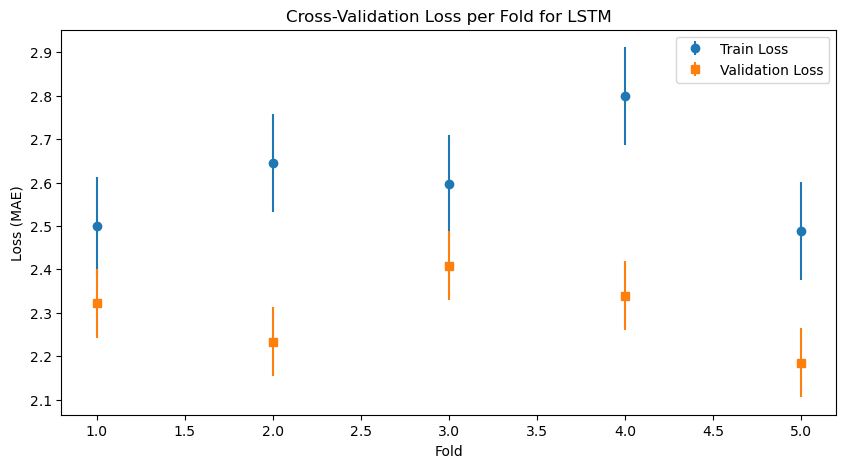


✅ Cross-validation results aggregated and saved!


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Number of folds
NUM_FOLDS = 5

# Store results
all_train_losses = []
all_val_losses = []
all_train_maes = []
all_val_maes = []
all_residuals = []

# Load results from all folds
for fold in range(1, NUM_FOLDS + 1):
    # Load training metrics
    with open(f"2Ddata_LSTM/training_metrics_fold{fold}.pkl", "rb") as f:
        metrics = pickle.load(f)

    # Load residuals
    with open(f"2Ddata_LSTM/residuals_fold{fold}.pkl", "rb") as f:
        residuals = pickle.load(f)

    # Store results
    all_train_losses.append(metrics["loss"][-1])  # Last epoch loss
    all_val_losses.append(metrics["val_loss"][-1])  # Last epoch validation loss
    all_train_maes.append(metrics["mae"][-1])  # Last epoch MAE
    all_val_maes.append(metrics["val_mae"][-1])  # Last epoch validation MAE
    all_residuals.append(residuals["mean_residual"])  # Mean residual per fold

# Compute mean and standard deviation
def mean_std(arr):
    return np.mean(arr), np.std(arr)

train_loss_mean, train_loss_std = mean_std(all_train_losses)
val_loss_mean, val_loss_std = mean_std(all_val_losses)
train_mae_mean, train_mae_std = mean_std(all_train_maes)
val_mae_mean, val_mae_std = mean_std(all_val_maes)
residual_mean, residual_std = mean_std(all_residuals)

# Print overall performance with standard deviation
print("\n📊 **Overall Cross-Validation Results**")
print(f"Train Loss: {train_loss_mean:.4f} ± {train_loss_std:.4f}")
print(f"Validation Loss: {val_loss_mean:.4f} ± {val_loss_std:.4f}")
print(f"Train MAE: {train_mae_mean:.4f} ± {train_mae_std:.4f}")
print(f"Validation MAE: {val_mae_mean:.4f} ± {val_mae_std:.4f}")
print(f"Residual Error: {residual_mean:.4f} ± {residual_std:.4f}")

# Plot Loss Trends
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, NUM_FOLDS + 1), all_train_losses, yerr=train_loss_std, fmt='o', label="Train Loss")
plt.errorbar(range(1, NUM_FOLDS + 1), all_val_losses, yerr=val_loss_std, fmt='s', label="Validation Loss")
plt.xlabel("Fold")
plt.ylabel("Loss (MAE)")
plt.legend()
plt.title("Cross-Validation Loss per Fold for LSTM")
plt.savefig("2Ddata_LSTM/cross_validation_loss.png")
plt.show()

# Save Aggregated Results
aggregated_results = {
    "train_loss_mean": train_loss_mean,
    "train_loss_std": train_loss_std,
    "val_loss_mean": val_loss_mean,
    "val_loss_std": val_loss_std,
    "train_mae_mean": train_mae_mean,
    "train_mae_std": train_mae_std,
    "val_mae_mean": val_mae_mean,
    "val_mae_std": val_mae_std,
    "residual_mean": residual_mean,
    "residual_std": residual_std,
    "all_train_losses": all_train_losses,
    "all_val_losses": all_val_losses,
    "all_train_maes": all_train_maes,
    "all_val_maes": all_val_maes,
    "all_residuals": all_residuals
}

with open("2Ddata_LSTM/aggregated_results.pkl", "wb") as f:
    pickle.dump(aggregated_results, f)

print("\n✅ Cross-validation results aggregated and saved!")


In [2]:
import numpy as np
import pickle
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Define label column names
LABEL_COLUMNS = ["Positive_Emotions", "Negative_Emotions", "Self_Esteem", "Meaning_in_Life", "Social_Support"]

# Number of Folds
NUM_FOLDS = 5
fold_files = [f"train_2d_fold{i}.pkl" for i in range(1, NUM_FOLDS + 1)]
test_files = [f"test_2d_fold{i}.pkl" for i in range(1, NUM_FOLDS + 1)]

# Create directory for saving models
os.makedirs("2Ddata_LSTM", exist_ok=True)

# ===== Step 1: Compute Global Max Sequence Length Across All Folds ===== #
global_max_seq_length = 0
for file_name in fold_files:
    with open(file_name, "rb") as f:
        fold_dict = pickle.load(f)
    max_length = max(len(seq) for seq in fold_dict["data"])
    global_max_seq_length = max(global_max_seq_length, max_length)

print(f"\n✅ Global Max Sequence Length: {global_max_seq_length}")

# ===== Step 2: Standardize Features Using All Training Data ===== #
scaler = StandardScaler()
all_train_features = []

for file_name in fold_files:
    with open(file_name, "rb") as f:
        fold_dict = pickle.load(f)
    columns = fold_dict["columns"]
    label_indices = [columns.index(col) for col in LABEL_COLUMNS]
    feature_indices = [i for i in range(len(columns)) if i not in label_indices and columns[i] != "participant_id"]
    X_raw = [np.array(seq[:, feature_indices], dtype=np.float32) for seq in fold_dict["data"]]
    X_flattened = np.vstack(X_raw)
    all_train_features.append(X_flattened)

scaler.fit(np.vstack(all_train_features))

# Save Scaler
with open("2Ddata_LSTM/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ StandardScaler saved!")

# ===== Step 3: Preprocess the Test Set ===== #
test_samples = 0
test_data = []
y_test = []

for test_file in test_files:
    with open(test_file, "rb") as f:
        test_dict = pickle.load(f)
    columns = test_dict["columns"]
    label_indices = [columns.index(col) for col in LABEL_COLUMNS]
    feature_indices = [i for i in range(len(columns)) if i not in label_indices and columns[i] != "participant_id"]
    X_test_raw = [np.array(seq[:, feature_indices], dtype=np.float32) for seq in test_dict["data"]]
    y_test_raw = [np.array(seq[:, label_indices], dtype=np.float32) for seq in test_dict["data"]]
    X_test_flat = np.vstack(X_test_raw)
    X_test_scaled = scaler.transform(X_test_flat)
    X_test_fixed = []
    start = 0
    for seq in X_test_raw:
        length = len(seq)
        X_test_fixed.append(X_test_scaled[start:start+length])
        start += length
    X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X_test_fixed, maxlen=global_max_seq_length, dtype="float32", padding="post"
    )
    test_data.append(X_test_padded)
    y_test.extend([seq[-1] for seq in y_test_raw])
    test_samples += len(X_test_padded)

y_test_final = np.array(y_test, dtype=np.float32)
print(f"\n✅ Test set preprocessed! Total test samples: {test_samples}")


2025-02-28 13:27:53.972960: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 13:27:54.012111: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 13:27:54.012131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 13:27:54.012156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 13:27:54.020005: I tensorflow/core/platform/cpu_feature_g


✅ Global Max Sequence Length: 74
✅ StandardScaler saved!

✅ Test set preprocessed! Total test samples: 263


In [3]:
# ===== Step 4: Define LSTM Model ===== #
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
        tf.keras.layers.GRU(64, return_sequences=False, kernel_regularizer=l2(0.005)),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.005)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(LABEL_COLUMNS), activation="linear")
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae", metrics=["mae"])
    return model

# ===== Step 5: Train and Evaluate the Model ===== #
model = build_model((global_max_seq_length, len(feature_indices)))
model.fit(
    np.vstack(test_data), y_test_final, epochs=50, batch_size=8, validation_split=0.2, verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)]
)

# Evaluate on Test Set
test_loss, test_mae = model.evaluate(np.vstack(test_data), y_test_final, verbose=1)
print(f"\n✅ Final Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Save the Model
model.save("2Ddata_LSTM/final_lstm_model.keras")
print("✅ Final LSTM model saved!")

2025-02-28 13:28:00.356159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 530 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-02-28 13:28:00.358415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20011 MB memory:  -> device: 1, name: NVIDIA A10, pci bus id: 0000:ca:00.0, compute capability: 8.6


Epoch 1/50


2025-02-28 13:28:05.081690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-02-28 13:28:06.003180: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5914ebd220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-28 13:28:06.003208: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10, Compute Capability 8.6
2025-02-28 13:28:06.003214: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A10, Compute Capability 8.6
2025-02-28 13:28:06.009245: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-28 13:28:06.155736: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 [==============================] - 8s 82ms/step - loss: 4.9099 - mae: 3.7881 - val_loss: 5.1597 - val_mae: 4.0446
Epoch 2/50
27/27 [==============================] - 1s 41ms/step - loss: 4.6766 - mae: 3.5673 - val_loss: 4.9482 - val_mae: 3.8453
Epoch 3/50
27/27 [==============================] - 1s 41ms/step - loss: 4.5085 - mae: 3.4109 - val_loss: 4.7680 - val_mae: 3.6763
Epoch 4/50
27/27 [==============================] - 1s 42ms/step - loss: 4.4434 - mae: 3.3569 - val_loss: 4.6004 - val_mae: 3.5197
Epoch 5/50
27/27 [==============================] - 1s 42ms/step - loss: 4.2690 - mae: 3.1931 - val_loss: 4.4321 - val_mae: 3.3617
Epoch 6/50
27/27 [==============================] - 1s 42ms/step - loss: 4.1230 - mae: 3.0575 - val_loss: 4.2655 - val_mae: 3.2053
Epoch 7/50
27/27 [==============================] - 1s 42ms/step - loss: 3.9394 - mae: 2.8838 - val_loss: 4.1191 - val_mae: 3.0686
Epoch 8/50
27/27 [==============================] - 1s 42ms/step - loss: 3.8134 - mae: 2.7675 